In [30]:
import pandas as pd
import numpy as np
import re
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime
import os
import logging
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [31]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all" 

Data Cleaning and Preprocessing

In [32]:
data = pd.read_excel("SPX.xlsx")
data['日期'] = pd.to_datetime(data['日期']).dt.date
data.columns = ['Code', 'Name', 'Date', 'Open', 'High', 'Low', 'Close', 'Change', 'Volume', 'Turnover_Mil']
data = data[data['Date'] >=  datetime.date(2015, 1, 1)]
# data['Date'] = data['Date'].dt.date
data

,Code,Name,Date,Open,High,Low,Close,Change,Volume,Turnover_Mil
22071,SPX.GI,标普500,2015-01-02,2058.90,2072.36,2046.04,2058.20,-0.0003,3.674338e+09,NaN
22072,SPX.GI,标普500,2015-01-05,2054.44,2054.44,2017.34,2020.58,-0.0183,5.011029e+09,0.00
22073,SPX.GI,标普500,2015-01-06,2022.15,2030.25,1992.44,2002.61,-0.0089,5.965445e+09,0.00
22074,SPX.GI,标普500,2015-01-07,2005.55,2029.61,2005.55,2025.90,0.0116,5.173363e+09,0.00
22075,SPX.GI,标普500,2015-01-08,2030.61,2064.08,2030.61,2062.14,0.0179,5.409027e+09,0.00
...,...,...,...,...,...,...,...,...,...,...
24722,SPX.GI,标普500,2025-04-28,5529.22,5553.66,5468.64,5528.75,0.0006,2.750592e+09,314036.58
24723,SPX.GI,标普500,2025-04-29,5508.87,5571.95,5505.70,5560.83,0.0058,2.852734e+09,295142.68
24724,SPX.GI,标普500,2025-04-30,5499.44,5581.84,5433.24,5569.06,0.0015,3.745265e+09,401116.95
24725,SPX.GI,标普500,2025-05-01,5625.14,5658.91,5597.35,5604.14,0.0063,3.216172e+09,386018.52


In [33]:
folder = 'FOMC_Txt'
filenames = os.listdir(folder)
date_pattern = re.compile(r'(\d{8})')
fomc_dates = []

for f in filenames:
    match = date_pattern.search(f)
    if match:
        try:
            fomc_dates.append(pd.to_datetime(match.group(1), format='%Y%m%d'))
        except Exception as e:
            print(f"Error parsing {f}: {e}")

fomc_dates = sorted(fomc_dates)
fomc_dates = [d.date() for d in fomc_dates]

results = []

for fomc_date in fomc_dates:
    # Get previous and next trading days
    previous_days = data[data['Date'] <= fomc_date]
    after_dates = data[data['Date'] > fomc_date]
    
    # Only process if we have both previous and next trading days
    if not previous_days.empty and not after_dates.empty:
        next_trading_day = after_dates.iloc[0]
        previous_day = previous_days.iloc[-1]
        
        change = (next_trading_day['Close'] - previous_day['Close']) / previous_day['Close']
        
        results.append({
            'FOMC_Date': fomc_date,
            'Prev_Close': previous_day['Close'],
            'Next_Trading_Date': next_trading_day['Date'],
            'Next_Close': next_trading_day['Close'],
            'pct': round(change * 100, 2)
        })

fomc_change_df = pd.DataFrame(results)

In [34]:
fomc_change_df.head()

,FOMC_Date,Prev_Close,Next_Trading_Date,Next_Close,pct
0,2015-03-18,2099.50,2015-03-19,2089.27,-0.49
1,2015-06-17,2100.44,2015-06-18,2121.24,0.99
2,2015-09-17,1990.20,2015-09-18,1958.03,-1.62
3,2015-12-16,2073.07,2015-12-17,2041.89,-1.50
4,2016-03-16,2027.22,2016-03-17,2040.59,0.66


In [42]:
def classify_change(pct):
    """
    Classifies daily percent change into 4 classes:
    0 = sharp drop, 1 = mild drop, 2 = mild rise, 3 = sharp rise
    """
    if pct > 1.5:       
        return 3        # Sharp Rise
    elif pct > 0:
        return 2        # Mild Rise
    elif pct > -1.5:    
        return 1        # Mild Drop
    else:
        return 0        # Sharp Drop

# Apply to DataFrame
fomc_change_df['label'] = fomc_change_df['pct'].apply(classify_change)

This labeling scheme maps market reactions into qualitative sentiment classes:

label = 3: Market had a strong positive response (e.g., +4.1%) \
label = 2: Market had a moderate positive response (e.g., +0.9%)\
label = 1: Market had a moderate decline (e.g., -1.4%)\
label = 0: Market had a strong negative response (e.g., -11.9%)

In [36]:
# Helper function to clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)               # Normalize whitespace
    text = re.sub(r'[^a-zA-Z ]', '', text)         # Remove numbers and punctuation
    return text.lower().strip()

# Build a dictionary: date → cleaned speech
speech_texts = {}
folder = 'FOMC_Txt'

for f in filenames:
    match = date_pattern.search(f)
    if match:
        try:
            date = pd.to_datetime(match.group(1), format='%Y%m%d').date()
            with open(os.path.join(folder, f), 'r', encoding='utf-8') as file:
                raw_text = file.read()
                speech_texts[date] = clean_text(raw_text)
        except Exception as e:
            print(f"Error reading {f}: {e}")

Check to make sure:

In [37]:
for date in fomc_change_df['FOMC_Date'].head():
    print(f"\n=== {date} ===\n{speech_texts.get(date, 'Missing')[:300]}")



=== 2015-03-18 ===
march   chair yellens p ress conference final transcript of chair yellens fomc press conference march   chair yellen good afternoon a s you know the federal open m arket committee this afternoon reaffirmed the c urrent  to  percent target ran ge for the federal funds rate we also updated our forward

=== 2015-06-17 ===
june   chair yellens press conference final transcript of chair yellens press conference june   chair yellen good afternoon toda y the federal open market c ommittee reaffirmed the current  to  perc ent target range for the fede ral funds rate since the committee last met in april the pace of job ga

=== 2015-09-17 ===
september   chair yellens press conference fina l transcript of chair yellen s press conference september   chair yellen good afternoon as you know from our policy statement released a short time ago the federal open market committee reaffirmed the current  to  percent target range for the federal f

=== 2015-12-16 ===
december   chair 

In [38]:
# Merge speech texts into your DataFrame
fomc_change_df['speech'] = fomc_change_df['FOMC_Date'].map(speech_texts)

# Check if any are missing
missing_speeches = fomc_change_df[fomc_change_df['speech'].isnull()]
print(f"Missing speeches: {len(missing_speeches)}")
missing_speeches[['FOMC_Date']]

Missing speeches: 0


,FOMC_Date


In [39]:
fomc_change_df.head()

,FOMC_Date,Prev_Close,Next_Trading_Date,Next_Close,pct,speech
0,2015-03-18,2099.50,2015-03-19,2089.27,-0.49,march chair yellens p ress conference final ...
1,2015-06-17,2100.44,2015-06-18,2121.24,0.99,june chair yellens press conference final tr...
2,2015-09-17,1990.20,2015-09-18,1958.03,-1.62,september chair yellens press conference fin...
3,2015-12-16,2073.07,2015-12-17,2041.89,-1.50,december chair yellens press conference fina...
4,2016-03-16,2027.22,2016-03-17,2040.59,0.66,march chair yellen s press conference final ...


# Logistic Regression Method:

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(fomc_change_df['speech'])
y = fomc_change_df['label']

feature_names = vectorizer.get_feature_names_out()

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear')

In [45]:
import pandas as pd
import numpy as np

def get_top_words_for_class(class_index, top_n=10):
    coefs = model.coef_[class_index]
    coef_df = pd.DataFrame({'word': feature_names, 'coef': coefs})
    top_words = coef_df.sort_values(by='coef', ascending=False).head(top_n)
    return top_words

# Example: Top words for class 3 (sharp rise)
top_words_class_3 = get_top_words_for_class(3, top_n=15)
print("Top predictive words for class 3 (sharp rise):")
print(top_words_class_3)

# Repeat for class 0 (sharp drop)
top_words_class_0 = get_top_words_for_class(0, top_n=15)
print("\nTop predictive words for class 0 (sharp drop):")
print(top_words_class_0)

Top predictive words for class 3 (sharp rise):
          word      coef
765  september  0.034856
176        cut  0.034129
803      solid  0.032489
68        base  0.024575
431   jennifer  0.020439
260    evolves  0.020166
986      wrote  0.019143
157    cooling  0.019128
350    growing  0.018111
225       dual  0.014898
941       vice  0.013843
788     single  0.013666
721  restraint  0.013257
710     report  0.011972
178    cutting  0.011186

Top predictive words for class 0 (sharp drop):
             word      coef
476           lls  0.180167
504       markets  0.160765
776        shocks  0.143582
633          powe  0.126269
675          rate  0.112870
438          june  0.105432
621         point  0.103804
170        credit  0.101686
764           sep  0.100904
722   restrictive  0.097939
928  unemployment  0.097131
116         china  0.090147
720       restore  0.088524
200  developments  0.087558
533        models  0.078513


In [26]:
print("Classes in model:", model.classes_)
print("Shape of model.coef_:", model.coef_.shape)

Classes in model: [0 1 2]
Shape of model.coef_: (3, 1000)


In [27]:
print(fomc_change_df['label'].value_counts())

label
2    29
1    27
0     4
Name: count, dtype: int64


# XgBoost Method

In [46]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [49]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# Define params
params = {
    'objective': 'multi:softprob',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'max_depth': 4,
    'eta': 0.1,
    'verbosity': 1,
}

model = xgb.train(params, dtrain, num_boost_round=100)

In [50]:
preds = model.predict(dtest)
y_pred = preds.argmax(axis=1)

print(classification_report(y_test, le.inverse_transform(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.60      0.50      0.55         6
           2       0.17      0.25      0.20         4
           3       0.00      0.00      0.00         1

    accuracy                           0.33        12
   macro avg       0.19      0.19      0.19        12
weighted avg       0.36      0.33      0.34        12



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

Text(0.5, 1.0, 'Top Words by Gain (XGBoost)')

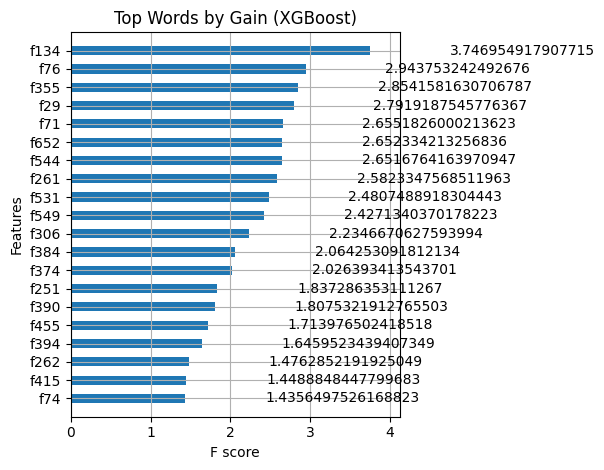

In [51]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=20, height=0.5, importance_type='gain')
plt.title("Top Words by Gain (XGBoost)")
plt.tight_layout()
plt.show()


In [52]:
feature_names = vectorizer.get_feature_names_out()
# To match names when needed:
model.feature_names = feature_names.tolist()


In [54]:
print(list(importance_dict.items())[:5])

[('ability', 0.2171945869922638), ('absolutely', 0.19969621300697327), ('act', 0.6558341979980469), ('actual', 0.13129979372024536), ('addition', 0.3287939131259918)]


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 20 artists>

Text(0.5, 0, 'Gain (Importance)')

Text(0.5, 1.0, 'Top 20 Predictive Words by Gain (XGBoost)')

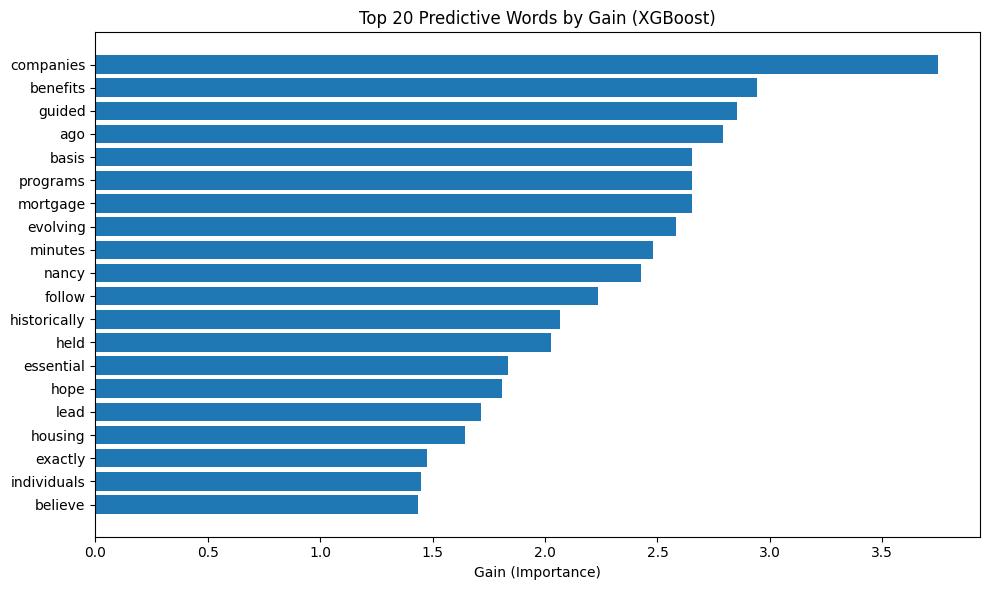

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
df_importance = pd.DataFrame(importance_dict.items(), columns=['word', 'gain'])

# Sort by gain
df_importance = df_importance.sort_values(by='gain', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_importance['word'][::-1], df_importance['gain'][::-1])
plt.xlabel("Gain (Importance)")
plt.title("Top 20 Predictive Words by Gain (XGBoost)")
plt.tight_layout()
plt.show()

In [56]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 547 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 6.9 MB/s eta 0:00:01     |██████████████████████▌         | 20.3 MB 7.5 MB/s eta 0:00:02
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, ...)

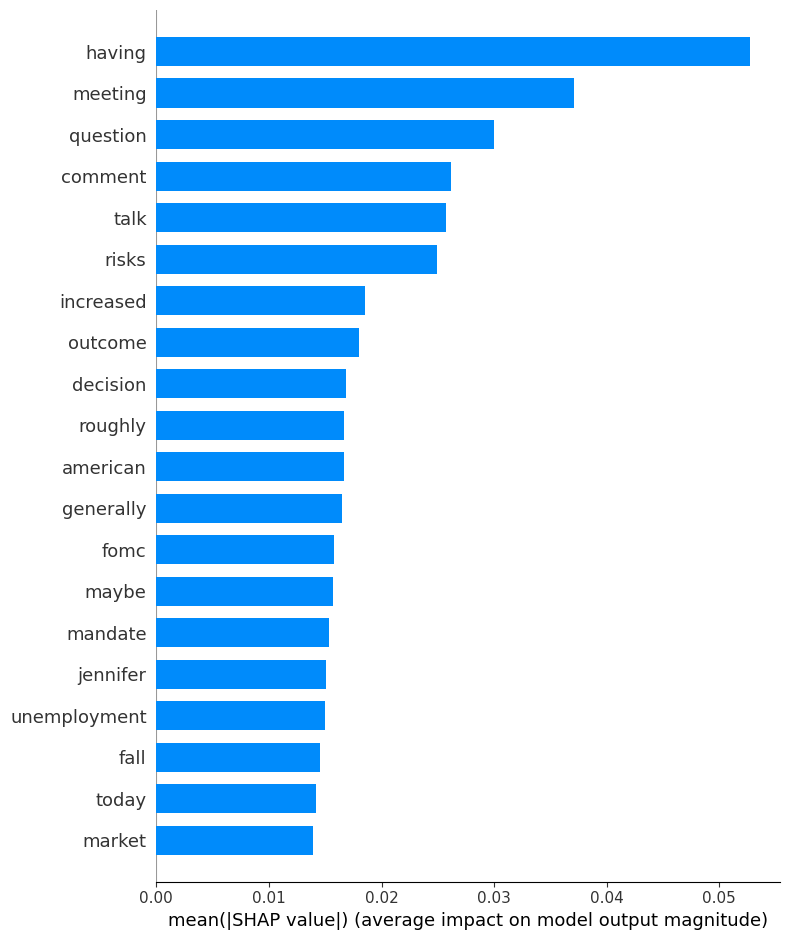

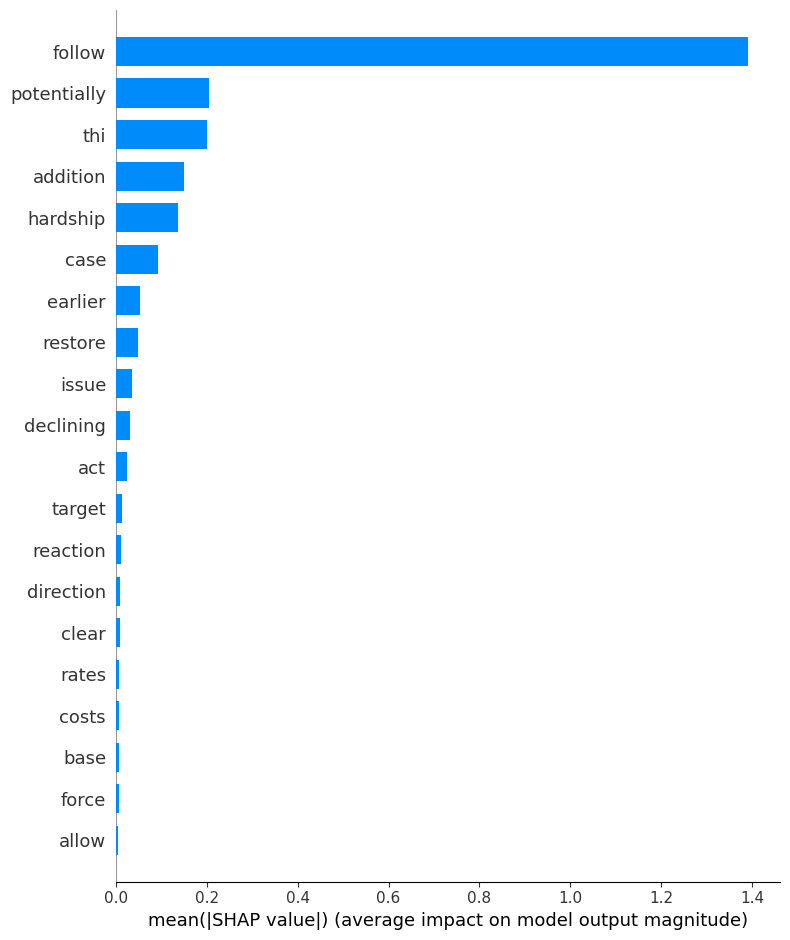

In [61]:
import shap
import numpy as np

# Convert sparse matrix to dense for SHAP
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Create and train the XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    max_depth=4,
    eta=0.1,
    verbosity=1
)
model.fit(X_train_dense, y_train_encoded)

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_dense)

# Class 3: Sharp Rise
shap.summary_plot(shap_values[..., 3], X_test_dense, feature_names=feature_names, show=True, plot_type="bar")

# Class 0: Sharp Drop
shap.summary_plot(shap_values[..., 0], X_test_dense, feature_names=feature_names, show=True, plot_type="bar")

In [63]:
import numpy as np
import pandas as pd

# For class 3
mean_abs_3 = np.abs(shap_values[..., 3]).mean(axis=0)
top_3_words = pd.Series(mean_abs_3, index=feature_names).sort_values(ascending=False).head(10)
print("Top words for class 3 (sharp rise):")
print(top_3_words)

# For class 0
mean_abs_0 = np.abs(shap_values[..., 0]).mean(axis=0)
top_0_words = pd.Series(mean_abs_0, index=feature_names).sort_values(ascending=False).head(10)
print("\nTop words for class 0 (sharp drop):")
print(top_0_words)


Top words for class 3 (sharp rise):
having       0.052753
meeting      0.037120
question     0.030025
comment      0.026139
talk         0.025726
risks        0.024917
increased    0.018567
outcome      0.018022
decision     0.016832
roughly      0.016687
dtype: float32

Top words for class 0 (sharp drop):
follow         1.391914
potentially    0.206031
thi            0.201630
addition       0.150252
hardship       0.135978
case           0.093016
earlier        0.052268
restore        0.048337
issue          0.036061
declining      0.032042
dtype: float32
